# An Accurate Implementation of the Studentized Range Distribution for Python

By Samuel Wallan, Dominic Chmiel, and Matt Haberland


## Introduction

In a world awash with data and computers, it is tempting to automate the process of scientific discovery by performing comparisons between many pairs of variables in hope of finding correlations. When frequentist hypothesis tests between pairs of variables are performed at a fixed confidence level, increasing the number of tests increases the probability of observing a "statistically significant" result even when the null hypothesis is actually true. Carefully designed tests, such as Tukey's HSD (Honestly Significant Difference) test, protect against this practice of "data dredging", producing p-values and confidence intervals that correctly account for the number of comparisons performed. Several such tests rely on the studentized range distribution, which models the range (i.e. the difference between the maximum and minimum values) of the means of samples from a normally distributed population. Although there are already implementations of these tests available in the scientific Python ecosystem, all of them rely on approximations of the studentized range distribution, which may not be accurate outside the range of inputs for which they are designed. We present the implementation of a reasonably fast and very accurate implementation of the studentized range distribution for SciPy, and we give evidence of its accuracy and performance.

## The Distribution

The studentized range probability density function (PDF) and cumulative distribution function (CDF) take the following forms, respectively [1]:

$$     f_\text{R}(q;k,\nu) = \frac{\sqrt{2\pi\,}\,k\,(k-1)\,\nu^{\nu/2}}{\Gamma(\nu /2)\,2^{\left(\nu/2-1\right)}}\int_0^\infty s^\nu \, \phi(\sqrt{\nu\,} \,s)\,\left[\int_{-\infty}^\infty \phi(z+q\,s)\,\phi(z)\, \left[\Phi(z+q\,s)-\Phi(z)\right]^{k-2} \, \mathrm{d}z\right] \, \mathrm{d}s \quad \mbox{and} \tag{1}
$$

$$ F_\text{R}(q;k,\nu) = \frac{\sqrt{2\pi\,}\,k\,\nu^{\nu/2}}{\,\Gamma(\nu/2)\,2^{(\nu/2-1)}\,} \int_0^\infty s^{\nu-1} \phi(\sqrt{\nu\,}\,s) \left[\int_{-\infty}^\infty \phi(z) \left[\Phi(z+q\,s)-\Phi(z)\right]^{k-1} \, \mathrm{d}z \right] \, \mathrm{d}s, \tag{2}$$

where $q > 0$ is the studentized range of sample means from $k>1$ groups, $\nu>0$ is the number of degrees of freedom used for determining the pooled sample variance, and $\phi(z)$ and $\Phi(z)$ represent the normal PDF and CDF.

In this document, no knowledge of the meaning of these terms is assumed; we simply take (1) and (2) as (messy!) integrals to be evaluated given real numbers $q$, $k$, and $\nu$.

## Implementations



We begin by presenting a sequence of implementations of the studentized range CDF, incrementally improving the speed and reliability, culminating in the implementation adopted by SciPy.

### A Very Direct Implementation

To establish a baseline, we evaluate the CDF exactly as written in (2), using nested calls to SciPy's `integrate.quad` to evaluate the double integral.

In [1]:
# ensure the most recent version of SciPy is installed
!pip install scipy==1.7.0

     |████████████████████████████████| 28.5MB 103kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import norm

phi = norm.pdf
Phi = norm.cdf

def cdf_quad(q, k, nu):
  
    def inner(z, s):
      return phi(z) * (Phi(z + q * s) - Phi(z))**(k - 1)

    def outer(s):
      inner_int = quad(inner, -np.inf, np.inf, args=(s,), 
                       epsabs=1e-12, limit=1000)[0]
      return s**(nu - 1) * phi(np.sqrt(nu) * s) * inner_int

    outer_int = quad(outer, 0, np.inf, epsabs=1e-12, limit=1000)[0]

    return (np.sqrt(2 * np.pi) * k * nu**(nu/2) /
            (gamma(nu/2) * 2**(nu/2 - 1)) * outer_int)

Reference [1] tabulates the studentized range CDF as a function of $q$, $k$, and $\nu$, reporting $q$ and $p=F(q; k, \nu)$ with two significant figures. It states that $F(3.77; 3, 12)=0.95$, and `cdf_quad` agrees to the precision available in the table.

In [3]:
qkv = 3.77, 3, 12
cdf_quad(*qkv)

0.9498176382397655

Unfortunately, our `cdf_quad` implementation is very slow.

In [4]:
time_quad = %timeit -o -r1 -n1 cdf_quad(*qkv)  # 13.6 s per loop

1 loop, best of 1: 12.3 s per loop


This implementation is easy to verify against the original formula and therefore serves as a valuable reference, but a faster implementation is needed for inclusion in SciPy.


###  Using `optimize.dblquad`.

To remove the overhead of repeated calls to `quad` and to enable more judicious choice of quadrature points $(s, z)$, we rearrange (2) to

$$ F(q; k, \nu) = \int_{0}^ {\infty} \int_{-\infty}^{\infty} s^{\nu-1} \frac{k\nu^{\nu/2}}{\Gamma(\nu/2)2^{\nu/2-1}}e^{-\nu s^2/2} \phi(z) [\Phi(sq + z) - \Phi(z)]^{k-1} \,dz \,ds \tag{3} $$

so that it can be computed with single call to SciPy's double integration function, `integrate.dblquad`. Besides moving the inner integral sign to the left, we have also moved the constant terms into the integral so that they can be included in the integrator's internal error estimate.

In [5]:
from scipy.integrate import dblquad

def integrand_python(s, z, *args):
    q, k, nu = args
    
    def inner(s, z):
        return phi(z) * (Phi(z + q * s) - Phi(z))**(k - 1)

    def outer(s, z):
        inner_int = inner(s, z)
        return s**(nu - 1) * phi(np.sqrt(nu) * s) * inner_int

    def whole(s, z):
        return (np.sqrt(2 * np.pi) * k * nu**(nu / 2) /
                (gamma(nu / 2) * 2**(nu / 2 - 1)) * outer(s, z))
        
    return whole(s, z)

def cdf_dblquad(q, k, nu):    
    return dblquad(integrand_python, -np.inf, np.inf, 0, np.inf, args=(q, k, nu))[0]

In [6]:
cdf_dblquad(*qkv)

0.949817638242155

In [7]:
time_dblquad = %timeit -o -r1 -n1 cdf_dblquad(*qkv)  # 13.2 s per loop

1 loop, best of 1: 11.7 s per loop


This simple change saves a small amount of computation time, but `cdf_dblquad` remains too slow for general use.

### Faster Normal PDF/CDF Evaluation

A more significant source of overhead is the use of SciPy's `norm.pdf` and `norm.cdf` for evaluation of $\phi$ and $\Phi$. The statistical distributions in `scipy.stats` have many useful features, but their methods are often much slower than direct calls to the underlying special functions. We eliminate this overhead by redefining `phi` and `Phi` more directly.


In [8]:
from scipy.special import ndtr  # the normal CDF 

phi_norm = norm.pdf
Phi_norm = norm.cdf

def phi(z):
  return (2 * np.pi)**(-.5) * np.exp(-0.5 * z * z)

def Phi(z):
  return ndtr(z)

Even the slowest runs of our new `phi` and `Phi` functions are much faster than the fastest runs of `norm.pdf` and `norm.cdf`.

In [9]:
z = 1
%timeit phi_norm(z)  # 99.6 µs per loop

The slowest run took 4.15 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 88.9 µs per loop


In [10]:
%timeit phi(z)  # 1.61 µs per loop

The slowest run took 25.19 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.36 µs per loop


In [11]:
%timeit Phi_norm(z)  # 83.4 µs per loop

10000 loops, best of 5: 101 µs per loop


In [12]:
%timeit Phi(z)  # 1.45 µs per loop

The slowest run took 29.94 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.18 µs per loop


Our functions have much less overhead than `norm`'s methods, so we expect that they will improve the speed of the `cdf_dblquad` evaluation significantly. Indeed, they do:

In [13]:
time_dblquad = %timeit -o -r1 -n1 cdf_dblquad(*qkv)  # 494 ms per loop

1 loop, best of 1: 428 ms per loop


At ~1/25 of the original execution time, this may be acceptable for a single function evaluation, but `cdf_dblquad` remains too slow for vectorized and iterative computations.

### Optimizing the Integrand with Cython

To improve the integration speed further, we focus on reducing the evaluation time of the integrand

$$ I = s^{\nu-1} \frac{k\nu^{\nu/2}}{\Gamma(\nu/2)2^{\nu/2-1}}e^{-\nu s^2/2} \phi(z) [\Phi(sq + z) - \Phi(z)]^{k-1} \tag{4}$$

using Cython. For reference, evaluating the integrand in pure Python takes more than ten microseconds.

In [14]:
s = 1
%timeit integrand_python(s, z, *qkv)

The slowest run took 7.53 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 14.2 µs per loop


#### Cythonizing Python Directly

As a high level programming language, Python's dynamic typing promotes ease of use but also adds significant computation time. An extension to the Python language, Cython, is designed to make C-like performance accessible from Python. Python-like code is converted to C or C++ and compiled, and an interface for use within Python is automatically generated.

To begin, we process the unmodified Python code with Cython.

In [15]:
%load_ext cython

In [16]:
%%cython -a

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The code in this cell is identical to that above; it
# must be repeated here to be processed with Cython.

import numpy as np
from scipy.special import gamma, ndtr

def phi(z):
  return (2 * np.pi)**(-.5) * np.exp(-0.5 * z * z)

def Phi(z):
  return ndtr(z)

def integrand_cythonized_python(s, z, *args): 
  q, k, nu = args

  def inner(s, z):
    return phi(z) * (Phi(z + q * s) - Phi(z))**(k - 1)

  def outer(s, z):
    inner_int = inner(s, z)
    return s**(nu - 1) * phi((nu ** .5)*s) * inner_int

  def whole(s, z):
    return (((2 * np.pi)**.5) * k * nu**(nu / 2) /
            (gamma(nu / 2) * 2**(nu /2 - 1)) * outer(s, z))

  return whole(s, z)


The bolder the highlighting in the lines above, the greater the overhead of API calls between the compiled code and Python. As most of the code is highlighted, we would not expect the Cythonized code to be much faster than the original.

In [17]:
%timeit integrand_cythonized_python(s, z, *qkv)

The slowest run took 12.22 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 8.68 µs per loop


Although this is slightly faster than the pure Python version, the speed can be improved further by minimizing the interaction between the compiled code and Python.

In [18]:
time_pure_cython = %timeit -o dblquad(integrand_cythonized_python, -np.inf, np.inf, 0, np.inf, args=qkv)[0] 

1 loop, best of 5: 227 ms per loop


#### Optimizing Cython


Every highlighted line hints at an interaction between the compiled code and Python that slows down execution. Therefore, we introduce a refactored, more Cythonic, implementation that 
- removes the Python interface for functions that need not be called from Python,
- declares types of variables and function returns,
- uses hard-coded constants,
- removes Python interaction relating to division, and
- imports functions native to C for computing $\phi$ and $\Phi$.

In [19]:
%%cython -a

cimport libc.math as math
cimport scipy.special.cython_special as cs

cdef double _phi(double z) nogil:
  cdef double inv_sqrt_2pi = 0.3989422804014327
  return inv_sqrt_2pi * math.exp(-0.5 * z * z)

cdef double _Phi(double z) nogil:
  return cs.ndtr(z)

cdef double inner(double s, double z, double q, double k, double nu) nogil:
  return _phi(z)*(_Phi(z+q*s)-_Phi(z))**(k-1)

cdef double outer(double s, double z, double q, double k, double nu) nogil:
  inner_int = inner(s, z, q, k, nu)
  return s**(nu - 1)*_phi((nu ** .5)*s)*inner_int

cdef double constants(double s, double z, double q, double k, double nu) nogil:
  num = ((2 * math.M_PI)**.5)* k *nu**(nu/2)
  denom = (math.tgamma(nu / 2) * 2**(nu / 2 - 1))
  return  num * (denom ** -1)

cpdef double integrand_cython(double s, double z, double q, double k, double nu):
  return constants(s, z, q, k, nu) * outer(s, z, q, k, nu)

Almost all Python interaction has been eliminated, so the evaluation time of the resulting integrand function is ~1/10 that of the previous Cython version and ~1/20 that of pure Python evaluation.

In [20]:
%timeit integrand_cython(s, z, *qkv)

The slowest run took 30.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 684 ns per loop


### Integration with Optimized Integrand

Integrating using the optimized Cython integrand is nearly three order of magnitude faster than the original Python implementation.

In [21]:
def cdf_cython(q, k, nu):    
    return dblquad(integrand_cython, -np.inf, np.inf, 0, np.inf, args=(q, k, nu))[0]
cdf_cython(*qkv)

0.9498176382421548

In [22]:
s, z = 1.4, 2.5
print(integrand_python(s, z, *qkv))
print(integrand_cythonized_python(s, z, *qkv))
print(integrand_cython(s, z, *qkv))

4.987225324127516e-07
4.987225324127516e-07
4.987225324127516e-07


In [23]:
cdf_dblquad(*qkv)

0.9498176382421548

In [24]:
time_cython = %timeit -o cdf_cython(*qkv)

10 loops, best of 5: 19.6 ms per loop


### Utilize SciPy's LowLevelCallable as the Integrand


There is one remaining Python interaction that slows down integration: because `cdf_integrand_cython_optimized` is declared using `cpdef` and therefore has a Python interface, we know that `dblquad` is using the Python interface to call the function. It would be faster if the compiled code underlying `dblquad` could interact with the compiled version of the integrand directly. That is precisely what SciPy's [`LowLevelCallable`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.LowLevelCallable.html) feature allows us to do.


*Note: There are multiple possible implementations of a `LowLevelCallable`; the following is one that works in Jupyter Notebooks. Jupyter Notebook's `%%cython` magic command doesn't provide an interface for using `.pxd` files in compliation, so we must write it to the directory ourselves. The following two cells are not part of SciPy's implementation of the studentized range distribution, but allow us to demonstrate the idea on Google Colab and in Jupyter Notebooks.*


In [25]:
# disregard this cell, it is only used to set up the LowLevelCallable.
%%cython -n tempName
cpdef fun():
  return None

In [26]:
# disregard this cell, it is only used to set up the LowLevelCallable.
import tempName
import os
path = tempName.__file__
path_split = os.path.split(path)[0]
path_pxd = os.path.join(path_split, "studentized_range.pxd")

with open(path_pxd , "w+") as f:
  f.write("cdef double genstudentized_range_cdf(int, double*, void*) nogil")

Once past that, we compile:

In [27]:
%%cython -f -n studentized_range
cimport libc.math as math
cimport scipy.special.cython_special as cs

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The following code mirrors the above Cython cell. The new method is at the
# bottom of this cell.

cpdef double studentized_range_cdf_const(double k, double nu):
  """Evaluates constant terms in the cdf integrand"""
  return (2 * math.pi) ** .5 * k * nu ** (nu/2) / (math.tgamma(nu / 2) * 2 ** (nu / 2 - 1)) #(k * (nu ** (nu/2))) / (math.tgamma(nu / 2) * (2 ** ((nu / 2) - 1)))

cdef double _phi(double z) nogil:
  """evaluates the normal PDF. Used in `studentized range`"""
  cdef double inv_sqrt_2pi = 0.3989422804014327
  return inv_sqrt_2pi * math.exp(-0.5 * z * z)

cdef double _Phi(double z) nogil:
  """evaluates the normal CDF. Used in `studentized range`"""
  return cs.ndtr(z)

cdef double inner(double s, double z, double q, double k, double nu) nogil:
  return _phi(z) * (_Phi(z + q * s) - _Phi(z)) ** (k-1)

cdef double outer(double s, double z, double q, double k, double nu) nogil:
  inner_int = inner(s, z, q, k, nu)
  return s ** (nu - 1) * _phi((nu ** .5) * s) * inner_int
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# This is new code that is formatted to work with `scipy.integrate.nquad`
cdef double genstudentized_range_cdf(int n, double * x, void * user_data) nogil:
    q = (<double *> user_data)[0]
    k = (<double *> user_data)[1]
    nu = (<double *> user_data)[2]
    cdf_const = (<double *> user_data)[3]
    z = x[0]
    s = x[1]
    return outer(s, z, q, k, nu) * cdf_const


In [28]:
import studentized_range
import ctypes
from scipy._lib._ccallback import LowLevelCallable
import numpy as np
from scipy.integrate import nquad

def cdf_llc(q, k, v):
  constant = studentized_range.studentized_range_cdf_const(k, v)
  usr_data = np.array([q, k, v, constant], float).ctypes.data_as(ctypes.c_void_p)
  studentized_range_cdf_lowlevelcallable = LowLevelCallable.from_cython(studentized_range, "genstudentized_range_cdf", usr_data)
  ranges = [(-np.inf, np.inf), (0, np.inf)]
  return nquad(studentized_range_cdf_lowlevelcallable, ranges=ranges)[0]

We could use this `LowLevelCallable` in `dblquad`, but since `dblquad` is implemented using SciPy's n-integral quadrature function `nquad`, we'll call `nquad` directly.

In [29]:
cdf_llc(*qkv)

0.9498176382396497

In [30]:
time_llc = %timeit -o cdf_llc(*qkv)

100 loops, best of 5: 9.37 ms per loop


## Other Improvements


### Logarithmization

The implementations above are reliable for moderate values of the arguments, but for extreme values, some terms of the integrand overflow or underflow before the calculation can be completed. The constant terms from (2)

$$
\frac{\nu^{\nu/2}}{\,\Gamma(\nu/2)\,2^{(\nu/2-1)}\,},
$$

for example, can overflow when the number of degrees of freedom $\nu$ is large.



In [31]:
nu = 400
try:  # catch the exception as to not interrupt cell execution
  nu**(nu/2)
except OverflowError as e:
  print(f"OverflowError: {e}")

OverflowError: (34, 'Numerical result out of range')


We circumvent this issue using the identity
$$
ab = \exp{(\log{(a)} + \log{(b)})}.
$$
That is, instead of calculating each term before taking the product (or quotient), we can:

1.   calculate the $\log$ of each term, which does not overflow or underflow,
2.   sum (or subtract) the $\log$s, and
3.   exponentiate the result.

For the expression above:
$$
\log \left( \nu ^ {\nu/2} \right) = \frac{\nu}{2} \log(\nu),
$$
$$
\log \left( 2^{\nu/2 - 1} \right) = \left( \frac{\nu}{2} - 1\right) \log(2),
$$
and the $\log$ of the gamma function is implemented as `scipy.special.loggamma`. In code,

In [32]:
from scipy.special import loggamma
log1 = nu/2 * np.log(nu)
log2 = loggamma(nu/2)
log3 = (nu/2 - 1)*np.log(2)

From these, we can calculate the desired result without experiencing any overflows.

In [33]:
np.exp(log1 - (log2 + log3))

8.150241623167703e+87

Although this excerpt from the integrand may still overflow at larger values of $\nu$, this technique tends to be very effective when applied to more of the integrand, including the terms that tend to be very small (e.g. $\phi(z)$). The code below re-implements the studentized range `LowLevelCallable` using this technique.

In [34]:
# disregard this cell, it is only used to set up the LowLevelCallable.
import tempName
import os
path = tempName.__file__
path_split = os.path.split(path)[0]
path_pxd = os.path.join(path_split, "studentized_range_log.pxd")

with open(path_pxd , "w+") as f:
  f.write("cdef double _studentized_range_cdf(int, double*, void*) nogil")

In [35]:
%%cython -n studentized_range_log
cimport libc.math as math
cimport scipy.special.cython_special as cs

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The following code mirrors the above cell. The new method is at the
# bottom of this cell.
cpdef double studentized_range_cdf_logconst(double k, double df):
  """Evaluates log of constant terms in the cdf integrand"""
  cdef double log_2 = 0.6931471805599453
  return (math.log(k) + (df / 2) * math.log(df)
          - (math.lgamma(df / 2) + (df / 2 - 1) * log_2))
  
cdef double phi(double z) nogil:
  """evaluates the normal PDF. Used in `studentized range`"""
  cdef double inv_sqrt_2pi = 0.3989422804014327
  return inv_sqrt_2pi * math.exp(-0.5 * z * z)

cdef double Phi(double z) nogil:
  """evaluates the normal CDF. Used in `studentized range`"""
  return cs.ndtr(z)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# New code    
cdef double _logphi(double z) nogil:
  """evaluates the log of the normal PDF. Used in `studentized_range`"""
  cdef double log_inv_sqrt_2pi = -0.9189385332046727
  return log_inv_sqrt_2pi - 0.5 * z * z

cdef double _studentized_range_cdf(int n, double[2] integration_var,
                                  void *user_data) nogil:
  q = (<double *> user_data)[0]
  k = (<double *> user_data)[1]
  df = (<double *> user_data)[2]
  log_cdf_const = (<double *> user_data)[3]

  s = integration_var[1]
  z = integration_var[0]

  # suitable terms are evaluated within logarithms to avoid under/overflows
  log_terms = (log_cdf_const
                + (df - 1) * math.log(s)
                - (df * s * s / 2)
                + _logphi(z))
  # multiply remaining term outside of log because it can be 0
  return math.exp(log_terms) * math.pow(Phi(z + q * s) - Phi(z), k - 1)

In [36]:
import studentized_range_log
import ctypes
from scipy._lib._ccallback import LowLevelCallable
import numpy as np
from scipy.integrate import nquad

def cdf_llc_log(q, k, v):
  log_const = studentized_range_log.studentized_range_cdf_logconst(k, v)
  usr_data = np.array([q, k, v, log_const], float).ctypes.data_as(ctypes.c_void_p)
  studentized_range_cdf_lowlevelcallable = LowLevelCallable.from_cython(studentized_range_log, "_studentized_range_cdf", usr_data)
  ranges = [(-np.inf, np.inf), (0, np.inf)]
  return nquad(studentized_range_cdf_lowlevelcallable, ranges=ranges)[0]

### Example Benefit
The logarithmized version is able to compute values at extreme values when the non-logarithmized version is not. 

In [37]:
qkv = 3.77, 3, 181
cdf_llc(*qkv)  # we expect this to return NaN

/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


nan

In [38]:
cdf_llc_log(*qkv)  # this should return a real value

0.9773080104791363

In [39]:
%timeit cdf_llc_log(*qkv)

100 loops, best of 5: 9.14 ms per loop


### ufunc
Statistical functions in SciPy are vectorized; that is, they accept NumPy arrays as inputs and perform the calculations element-wise. We endow our function with this capability by making it a NumPy universal function ("ufunc"). `np.frompyfunc` makes this very simple:

In [40]:
cdf_scipy = np.frompyfunc(cdf_llc_log, nin=3, nout=1)

This has little impact on the function for scalar inputs.

In [41]:
qkv = 3.77, 3, 12
cdf_scipy(*qkv)

0.9498176382396516

But now the function supports array inputs, broadcasting arrays of different shapes according the usual conventions.

In [42]:
q = np.asarray([1.77, 2.77, 3.77])
k = np.asarray([2, 3, 4])
v = np.asarray([10, 11, 12])
cdf_scipy(q, k[..., None], v).astype(np.float64)

array([[0.76079184, 0.92401548, 0.97942993],
       [0.54806443, 0.83128595, 0.94981764],
       [0.38911585, 0.73969832, 0.91615474]])

In addition to being more reliable and providing additional input options, this implementation maintains the speed of the non-logarithmized version.

In [43]:
time_scipy = %timeit -o cdf_scipy(*qkv) # 5.48 ms

100 loops, best of 5: 5.65 ms per loop


The implementation developed for SciPy is very similar, so we refer to this as the "SciPy implementation" below.

## Quantifying Speed Improvements

The graph below represents typical execution time of each of the versions of the studentized range CDF code above: 
- "Python" - a very direct implementation
- "Optimized Python" - Python with faster `phi` and `Phi`
- "Unoptimized Cython" - directly cythonized Python
- "Cython" - integration with optimized integrand
- "LLC" - implementation with improved LowLevelCallable with precomputed constants 
- "SciPy" - LLC implementation with logarithmization and ufunc abilities 


In [44]:
%%capture
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

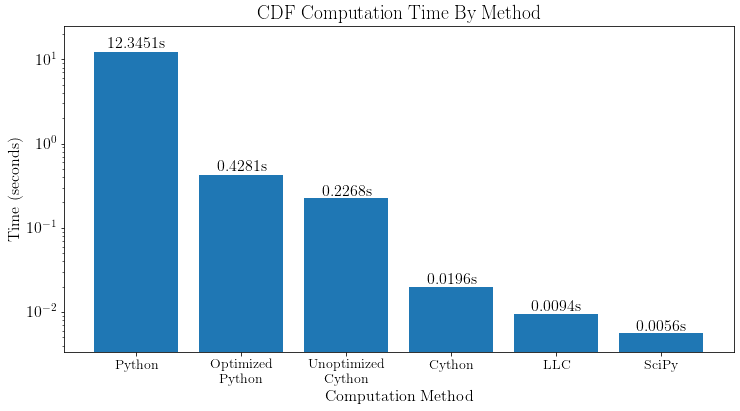

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['figure.figsize'] = [12, 6]
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
inputs = [time_quad,
          time_dblquad,
          time_pure_cython,
          time_cython,
          time_llc,
          time_scipy]
index = np.arange(len(inputs))
times = [input.best for input in inputs]
t = ax.bar(index, times)
ax.set_yscale('log')
ax.set_ylabel("Time (seconds)")
ax.set_xlabel("Computation Method")

ax.set_title("CDF Computation Time By Method")
ax.set_xticks(index)
labels = ("Python", "Optimized\nPython", "Unoptimized\nCython", "Cython", "LLC", "SciPy" )
ax.set_xticklabels(labels)

# put label on top of each bar
for index, data in enumerate(times):
  plt.text(x = index,
           y = data ,
           s=f"{data:.4f}s",
           ha='center',
           va='bottom')
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.ylim(np.min(times)**1.1,10**1.4)

plt.show()

## Establishing Accuracy

In this section, we benchmark the accuracy of the SciPy implementation against other open source implementations.

### Determining Ground Truth

Tables of the studentized range distribution give only a few significant figures of the CDF for a handful of values of the arguments, so these references are insufficient for addressing the SciPy implementation's accuracy. Other Python implementations, such as those in the `statsmodels` [3] and `pinguin` [4] packages, interpolate between tabulated values, so these suffer from the same limitations as the original tables. One of the most widely used implementations, R's `ptukey` and `qtukey` functions [5], only guarantees that "`qtukey` will be accurate to the 4th decimal place". We seek a more precise implementation to serve as "ground truth".

For this, we turn to [`mpmath`](https://mpmath.org/), a Python library for floating point arithmetic with arbitrary precision (at a cost of increased execution time). We begin with a straightforward implementation of the distribution CDF in `mpmath`. Note that this `cdf_mp` function also accepts arguments `method`, the quadrature rule used (tanh-sinh or Gauss-Legendre), and `dps`, the desired number of digits of precision.

In [46]:
from mpmath import gamma, pi, erf, exp, sqrt, quad, inf, mpf
from mpmath import npdf as phi
from mpmath import ncdf as Phi
from mpmath import mp

def cdf_mp(q, k, nu, method, dps):
  mp.dps = dps
  q, k, nu = mpf(q), mpf(k), mpf(nu)

  def inner(s, z):
    return phi(z)*(Phi(z+q*s)-Phi(z))**(k-1)

  def outer(s, z):
    return s**(nu-1)*phi(sqrt(nu)*s)*inner(s, z)

  def whole(s, z):
    return sqrt(2*pi)*k*nu**(nu/2) / (gamma(nu/2)*2**(nu/2-1))*outer(s, z)
    
  res = quad(whole, [0, inf], [-inf, inf], error=False,
             method=method, maxdegree=10)
  return res

To establish the accuracy of this approach, we first checked that the results of this implementation match all available digits of tabulated values. Crucially, we also observe that:

*   the two integration methods (tanh-sinh and Gauss-Legendre quadrature) agree in nearly all of the requested digits of precision and
*   the calculation converges as the the number of digits of precision is increased.

To see this, we label as "ground truth" the average of the results of the Gauss-Legendre and tanh-sinh methods with `dps=25`.

In [47]:
def cdf_mp_gl(q, k, nu, dps):
  return cdf_mp(q, k, nu, method='gauss-legendre', dps=dps)

def cdf_mp_ts(q, k, nu, dps):
  return cdf_mp(q, k, nu, method='tanh-sinh', dps=dps)
  
def cdf_ground_truth(q, k, nu):
  return (cdf_mp_ts(q, k, nu, dps=25) + cdf_mp_gl(q, k, nu, dps=25))/2


Then we check that the difference between the estimates and this ground truth decreases as the number of digits of precision increases.

In [48]:
# calculate estimates using both integration methods and several values of `dps`
# Note: this takes several minutes to execute, the results have been pre-computed
dps_range = range(6, 26, 1)

q, k, v = 4.577, 10, 10  # arbitrary, but results are typical

"""
# calculate the "ground truth"
ground_truth = cdf_ground_truth(q, k, v)

cdf_ts = []
cdf_gl = [] 
for dps in dps_range:
  cdf_ts.append(cdf_mp_ts(q, k, v, dps=dps))
  cdf_gl.append(cdf_mp_gl(q, k, v, dps=dps))
"""

!git clone https://github.com/swallan/srdcolab.git
mp.dps = 25
with open('srdcolab/cdf_gl_dps.npy', 'rb') as f:
    cdf_gl = np.load(f, allow_pickle=True)
with open('srdcolab/cdf_ts_dps.npy', 'rb') as f:
    cdf_ts = np.load(f, allow_pickle=True)
ground_truth = (cdf_gl[-1] + cdf_ts[-1])/2

Cloning into 'srdcolab'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 33 (delta 14), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (33/33), done.


Text(0.5, 0, 'Digits of Precision')

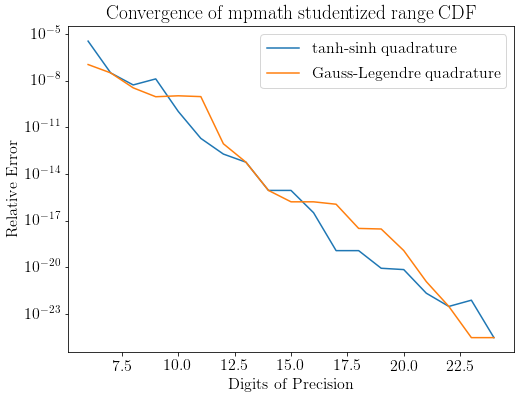

In [49]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# styling setup
plt.rc('font', family='serif')
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()

# prepare the data
# we are looking for convergence: the difference between subsequent estimates
# and our "ground truth" should decrease as the number of digits of precision
# increases
x = np.asarray(list(dps_range))[:-1]
cdf_ts = np.asarray(cdf_ts)
cdf_gl = np.asarray(cdf_gl)
y1 = np.abs(cdf_ts[:-1] - ground_truth)/np.abs(ground_truth)
y2 = np.abs(cdf_gl[:-1] - ground_truth)/np.abs(ground_truth)

# plot the results
ax.semilogy(x, y1, x, y2)
ax.legend(("tanh-sinh quadrature", "Gauss-Legendre quadrature"))
ax.set_title(f"Convergence of mpmath studentized range CDF")
ax.set_ylabel("Relative Error")
ax.set_xlabel("Digits of Precision")

NumPy floating point values (`dtype=np.float64`) can only resolve relative differences on the order of $1 \times 10^{-16}$, yet we observe that our `mpmath` implementation converges to far better precision. This suggests that `cdf_ground_truth` is suitable for use as a reference implementation.

### Experimental Setup

The population of parameter values (i.e., the distribution of $q, k, $ and $\nu$) under investigation was designed to be representative of common use cases.
 1. $k$ was sampled uniformly in the range 2, the minimum value supported by the distribution, through 120, the largest finite value provided by most available reference tables.
 2. $\nu$ was sampled uniformly in the range 1 through 100, with bounds chosen for the highest and lowest finite values provided by reference tables.
 3.  Using inverse transform sampling, $q$ was sampled from the studentized range distribution defined by the given $k$ and $\nu$ . That is, for each $k$ and $\nu$, a $p$ value was sampled uniformly in the range 0 through 1, and we use the value of $q$ that satisfies $p = F(q; k, \nu)$.

At each of 1000 points randomly selected from this population, we evaluated the studentized range distribution CDF using each implementation (SciPy, `statsmodels`, R's `ptukey`, and `mpmath`).

We use the `mpmath` implementation at 18 digits of precision as the reference value, which we denote $F_{MP}$. Note that as a result of the agreement between the tanh-sinh and Gauss-Legendre methods of integration, we compare against the gauss-legendre method only in the name of speed. Similarly, we denote the SciPy, StatsModels, and R implementations as $F_{SP}$, $F_{SM}$, and $F_{R}$, respectively.

To load the pre-computed data,

In [50]:
cdf_mp = np.load('srdcolab/cdf_gl.npy')
cdf_sm = np.load('srdcolab/cdf_sm.npy')
cdf_sp = np.load('srdcolab/cdf_scipy.npy')
cdf_r = np.load('srdcolab/cdf_r.npy')

The relative errors for SciPy, StatsModels, and R are then calculated relative to the reference value from `mpmath`:

$$
e_{SP} =  \frac{\left| F_{SP}(q; k, v) - F_{MP}(q; k, v) \right|}{\left| F_{MP}(q; k, v) \right|} \\
e_{SM} =  \frac{\left| F_{SM}(q; k, v) - F_{MP}(q; k, v) \right|}{\left| F_{MP}(q; k, v) \right|} \\
e_{R} =  \frac{\left| F_{R}(q; k, v) - F_{MP}(q; k, v) \right|}{\left| F_{MP}(q; k, v) \right|} \\
$$

  


In [51]:
e_sp = np.abs(cdf_sp - cdf_mp)/np.abs(cdf_mp)
e_sm = np.abs(cdf_sm - cdf_mp)/np.abs(cdf_mp)
e_r = np.abs(cdf_r - cdf_mp)/np.abs(cdf_mp)

### Results

A simple way to visualize the error of each implementation is a box and whisker plot. An advantage of this visualization is that is shows not only a point estimate of the "average" error (in this case, the median), but also represents the spread of the error: the box represents data between the first and third quartile, with a line indicating the median. Whiskers indicate the 5th and 95th percentile data, and outliers beyond these limits are represented as circles.

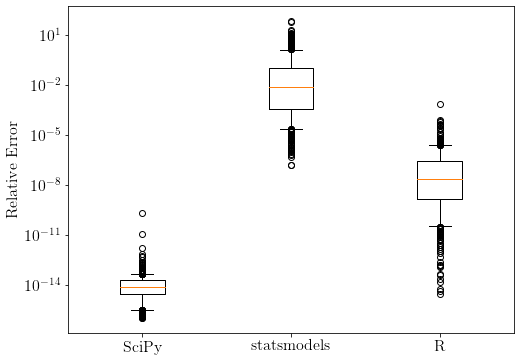

In [52]:
fig, ax = plt.subplots()
ax.boxplot(np.array([e_sp, e_sm, e_r[~np.isnan(e_r)]], dtype='object'),
           whis=(5, 95), labels=("SciPy", "statsmodels", "R"))
ax.set_ylabel("Relative Error")
ax.set_yscale('log')

Here, we see that even the greatest observed error of the SciPy implementation is less than the lowest error of the statsmodels implementation and lower than the first quartile error of the R implementation.

For most users, this is likely to be satisfactory evidence of the accuracy and reliability of the SciPy implementation. Nonetheless, we take this opportunity to share two other new features of SciPy that might be used for analysis of the results.

#### (Bootstrapped) Confidence Intervals of the Geometric Mean Error

Suppose we are interested in the true value of some statistic, such as an "average" error, for each implementation. We show here how the new `scipy.stats.bootstrap` can be used to estimate a 95% confidence interval for this statistic.

Since the data are spread over several orders of magnitude, a reasonable measure of central tendency is the geometric mean. We compute confidence intervals for the geometric mean below, but note that the code can easily be adapted to compute confidence intervals for some other statistic.

In [53]:
import scipy.stats as stats
from scipy.stats.mstats import gmean

def statistic(data, *args, **kwds):
  # For some arguments, the error between the SciPy implementation and the 
  # ground truth is numerically zero. This would make the geometric mean zero,
  # regardless of other values. To get a conservative (high) estimate of the
  # geometric mean (if the error between SciPy's implementation and ground
  # truth could be resolved), we set zero values to the minimum value that can
  # be resolved.
  data = data.copy()
  data[data == 0] = np.finfo(float).eps
  return gmean(data, *args, **kwds)

rng = np.random.default_rng(95132214857698234)  # arbitary seed
confidence = .95

# SciPy Implementation CI
res_cython = stats.bootstrap((e_sp,), statistic, confidence_level=confidence, 
                             random_state=rng)
ci_cython = res_cython.confidence_interval

# statsmodels Implementation CI
res_sm = stats.bootstrap((e_sm,),statistic, confidence_level=confidence, 
                         random_state=rng)
ci_sm = res_sm.confidence_interval        

# R implementation CI
# the R implementation does not support parameters where $\nu = 1$. For the sake
# of quantitative comparison, these results have been filtered out.
r_errors_no_nans = e_r[~np.isnan(e_r)]  
res_r = stats.bootstrap((r_errors_no_nans,), statistic, 
                        confidence_level=confidence, random_state=rng)
ci_r = res_r.confidence_interval 

# Display the results
tbl = (
f"""
                Geometric Mean of Error
          {confidence*100}% Bootstrap Confidence Interval

implementation |  lower ci  |  upper ci  | sample gmean
-------------------------------------------------------
SciPy          | {ci_cython.low:.3e}  | {ci_cython.high:.3e}  |  {statistic(e_sp):.3e}
-------------------------------------------------------
StatsModels    | {ci_sm.low:.3e}  | {ci_sm.high:.3e}  |  {statistic(e_sm):.3e}
-------------------------------------------------------
R              | {ci_r.low:.3e}  | {ci_r.high:.3e}  |  {statistic(r_errors_no_nans):.3e}
"""
)
print(tbl)


                Geometric Mean of Error
          95.0% Bootstrap Confidence Interval

implementation |  lower ci  |  upper ci  | sample gmean
-------------------------------------------------------
SciPy          | 6.476e-15  | 7.833e-15  |  7.109e-15
-------------------------------------------------------
StatsModels    | 5.092e-03  | 7.830e-03  |  6.328e-03
-------------------------------------------------------
R              | 1.281e-08  | 2.046e-08  |  1.629e-08



In repeated computational experiments, approximately 95% of confidence intervals computed in this way would contain the true value of the geometric mean of the error.

#### Binomial Test of Accuracy


Suppose we wish to assess whether an implementation is "sufficiently accurate" for a "large percentage" of possible inputs. For example, with confidence 95%, is the relative error of the SciPy implementation better than $1\times 10^{-12}$ for at least 99% of possible inputs? To answer this question, we can use the binomial test. The null hypothesis is that the true percentage of the population for which the implementation is "accurate" is 99%; the alternative is that the true percentage of the population for which the implementation is "accurate" is _greater_ than 99%.

In [54]:
from scipy.stats import binomtest
m = np.count_nonzero(e_sp < 1e-12)
n = len(e_sp)
res = binomtest(m, n, p=.99, alternative="greater")
print(f"pvalue = {res.pvalue:f}")

pvalue = 0.010073


The p-value, $0.010073$, is less than our desired significance level $0.05$, so the null hypothesis is rejected in favor of the alternative.

The new `scipy.stats.binomtest` (which replaced `scipy.stats.binom_test` in SciPy 1.7.0) also provides a confidence interval for the proportion.

In [55]:
res.proportion_ci(confidence_level=.95)

ConfidenceInterval(low=0.992264755281518, high=1.0)

If we were to repeat this experiment, the reported confidence interval would contain the true value of the proportion (the percentage of the population for which the implementation is "sufficiently accurate") 95% of the time.

## Conclusion

The [PR](https://github.com/scipy/scipy/pull/13732) for the addition of this distribution was successfully merged into the main branch of SciPy on May 26, 2021. The distribution's PDF and moments were implemented using similar techniques to those demonstrated here for the CDF. Other functions of the distribution are given by generic implementations of the `scipy.stats.rv_continuous` class that rely on the PDF and CDF; e.g., the percentage point function (PPF) numerically inverts the CDF. For example,

In [56]:
from scipy.stats import studentized_range
p = 0.95
q = studentized_range.ppf(p, 3, 12)
cdf = studentized_range.cdf(q, 3, 12)
print(cdf)

0.9500000000000001


Tukey's Honestly Significant Difference test, which uses the studentized range's critical values, is currently under review in [gh-13002](https://github.com/scipy/scipy/pull/13002). 

## References

[1] R. E. Lund and J. R. Lund, “Algorithm AS 190: Probabilities and Upper Quantiles for the Studentized Range,” Applied Statistics, vol. 32, no. 2, p. 204, 1983.

[2] H. L. Harter, “Use of Tables of Percentage Points of Range and Studentized Range,” Technometrics, vol. 3, no. 3, pp. 407–411, 1961.

[3]  J. Perktold et al. (2021). StatsModels: statistical modeling and econometrics in Python. [Online] Available: https://github.com/statsmodels/statsmodels, Accessed on Jul 13, 2021.

[4] Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026

[5] Tukey: The Studentized Range Distribution. [Online] Available: https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/Tukey, Accessed on Jul 13, 2021.